In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
def extract_params(directory_name, units):
    # Split the directory_name and construct the parameter dictionary directly
    params_dict = {}
    first_part_params = directory_name.split(',')
    for param in first_part_params:
        name, val = param.split('=')
        
        # Remove square brackets from the value
        val = val.replace('[', '').replace(']', '')

        # Extract numeric part of the value using regex
        numeric_val = re.search(r'-?\d+\.?\d*', val)
        if numeric_val:
            params_dict[name] = numeric_val.group()
            # Storing the unit separately in the units dictionary
            unit = re.search(r'[a-zA-Z]+$', val)
            if unit and name not in units:
                units[name] = unit.group()
        else:
            # In case the value is not numeric (like 'method'), just save it directly
            params_dict[name] = val
    return params_dict, units

def read_accuracy(file_path):
    # Open the file and read the value
    with open(file_path, 'r') as f:
        contents = f.read()

    # Extract the accuracy value using regex
    accuracy_match = re.search(r"Accuracy: (\d+(\.\d+)?)%", contents)
    return accuracy_match.group(1) if accuracy_match else None

def clean_file_name(file):
    unwanted_parts = ["model_accuracy_", ".txt", "_full_pixel"]
    for part in unwanted_parts:
        file = file.replace(part, "")
    return file

def build_dataframe(data, data_full_pixel):
    df = pd.DataFrame(data)
    df['accuracy'] = pd.to_numeric(df['accuracy'])
    if data_full_pixel:
        df_full_pixel = pd.DataFrame(data_full_pixel)
        df_full_pixel['accuracy(full pixel)'] = pd.to_numeric(df_full_pixel['accuracy(full pixel)'])
        merge_columns = df.columns[:-1].tolist()
        df = pd.merge(df, df_full_pixel, how='outer', on=merge_columns)
    return df

def extract_values(main_path):
    # Prepare an empty list to store data
    data = []
    data_full_pixel = []

    # Initialize dictionary to store units
    units = {}

    # Loop through each directory
    for root, dirs, _ in os.walk(main_path):
        # Check if the specific subdirectory is in the directory
        for directory in dirs:
            match = re.match(r"model_test_e(\d+)$", directory)
            if match:
                model_number = match.group(1)
                model_dir = os.path.join(root, directory)

                # Iterate over files in the model directory
                for _, _, files in os.walk(model_dir):
                    for file in files:
                        if re.search(r'model_accuracy_.*_regressor(_full_pixel)?\.txt$', file):
                            file_path = os.path.join(model_dir, file)

                            # Check if the specific file is in the subdirectory
                            if os.path.exists(file_path):
                                # Call the helper functions
                                directory_name = re.search(r"\((.*?)\)", os.path.basename(root)).group(1)
                                params_dict, units = extract_params(directory_name, units)
                                params_dict['used_regressor'] = clean_file_name(file)
                                params_dict['epoch'] = model_number
                                
                                # Check if it's a full pixel file
                                if "_full_pixel" in file:
                                    params_dict["accuracy(full pixel)"] = read_accuracy(file_path)
                                    data_full_pixel.append(params_dict)
                                else:
                                    params_dict['accuracy'] = read_accuracy(file_path)
                                    data.append(params_dict)

    # Call the helper function to build DataFrame
    df = build_dataframe(data, data_full_pixel)
    print('data:',len(data))
    print('data_full_pixel:',len(data_full_pixel))
    print('Detected units:', units)

    return df

In [127]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def darken_cmap(cmap):
    cmap = cm.get_cmap(cmap)
    cmap_data = cmap(np.arange(cmap.N))
    
    # change the first RGB columns in each row (which form the colors) by taking
    # half their current value, effectively darkening the colormap
    cmap_data[:, :3] = cmap_data[:, :3] * 0.8
    
    return LinearSegmentedColormap.from_list('darkened_' + cmap.name, cmap_data, cmap.N)

def plot_avg_accuracy(df, x_param, line_param, filter_out=None, figsize=(10,6), points_notation=None,score_column='accuracy'):
    # Apply the filter condition if provided
    if filter_out:
        for column, conditions in filter_out.items():
            if not isinstance(conditions, list):
                conditions = [conditions]
            for condition in conditions:
                df = df[df[column] != condition]

    # Calculate average accuracy and standard deviation grouped by x_param and line_param
    grouped = df.groupby([x_param, line_param]).agg({score_column: ['mean', 'std', 'size']}).reset_index()

    # Flatten the multi-level columns
    grouped.columns = ['_'.join(t).rstrip('_') for t in grouped.columns.values]

    # Rename columns for convenience
    grouped = grouped.rename(columns={f"{score_column}_mean": score_column, f"{score_column}_std": "std", f"{score_column}_size": "counts"})

    # Get unique line parameters
    unique_lines = grouped[line_param].unique()

    # Calculate the average count
    avg_count = grouped['counts'].mean()

    # Create a colormap and normalize object
    cmap = darken_cmap('RdYlGn_r') # '_r' indicates reverse order, so high values will be red and low values green
    norm = colors.Normalize(vmin=5, vmax=20) # values <=5 will be most green, >=20 will be most red

    # Create a new figure
    plt.figure(figsize=figsize)

    # Loop through each unique line parameter
    for line_val in unique_lines:
        # Filter the grouped DataFrame for the current line parameter
        line_data = grouped[grouped[line_param] == line_val]

        # Plot the data for this line parameter
        plt.plot(line_data[x_param], line_data[score_column], label=str(line_val))

        # Add data point count or standard deviation as text annotation next to each data point if points_notation is not None
        if points_notation:
            for i, point in line_data.iterrows():
                if points_notation == 'std':
                    annotation = f"({point['std']:.1f})"
                    color = cmap(norm(point['std'])) if point['std'] <= 20 else cmap(1.0) # Maximum red color for std>20
                    plt.text(point[x_param], point[score_column], annotation, color=color, fontweight='bold')
                elif points_notation == 'sp_count':
                    annotation = f"({point['counts']})"
                    color = 'black'
                    plt.text(point[x_param], point[score_column], annotation, color=color)
                elif points_notation == 'val':
                    annotation = f"{point[score_column]:.2f}"
                    color = 'black'
                    plt.text(point[x_param], point[score_column], annotation, color=color)
                

    # Add a legend, grid, labels and a title
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.xlabel(f"{x_param} (Avg Count: {avg_count:.1f})")
    plt.ylabel(f'Average acc ')
    plt.title(f'Average {score_column} vs [{x_param}] for different [{line_param}]')
    plt.show()

def all_plots(data_df,figsize,filter_out={},points_notation=False):
    for x_axis in data_df.columns[:-2]:
        for p_lines in data_df.columns[:-2]:
            if x_axis == p_lines:
                continue
            print(x_axis,p_lines)
            plot_avg_accuracy(data_df, x_axis, p_lines,filter_out=filter_out,figsize=figsize,points_notation=points_notation)

In [121]:
print('Full size:',120*4*3)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/25.0_large_df_method_compare/plots'
case25_0_ = extract_values(path)

print(len(case25_0_))
case25_0_

Full size: 1440
data: 1440
data_full_pixel: 1440
Detected units: {'Bt': 'mT', 'df': 'GHz'}
1440


,method,Bt,df,used_regressor,epoch,accuracy,accuracy(full pixel)
0,equal,4.0,1.5,max_value_regressor,49,100.00,100.00
1,equal,4.0,1.5,logistic_regressor,49,100.00,100.00
2,equal,4.0,1.5,diff_regressor,49,78.33,47.50
3,equal,4.0,1.5,max_value_regressor,74,100.00,100.00
4,equal,4.0,1.5,logistic_regressor,74,100.00,100.00
...,...,...,...,...,...,...,...
1435,equal,3.0,1.5,logistic_regressor,0,99.17,84.17
1436,equal,3.0,1.5,diff_regressor,0,95.83,67.50
1437,equal,3.0,1.5,max_value_regressor,99,100.00,50.00
1438,equal,3.0,1.5,logistic_regressor,99,100.00,100.00


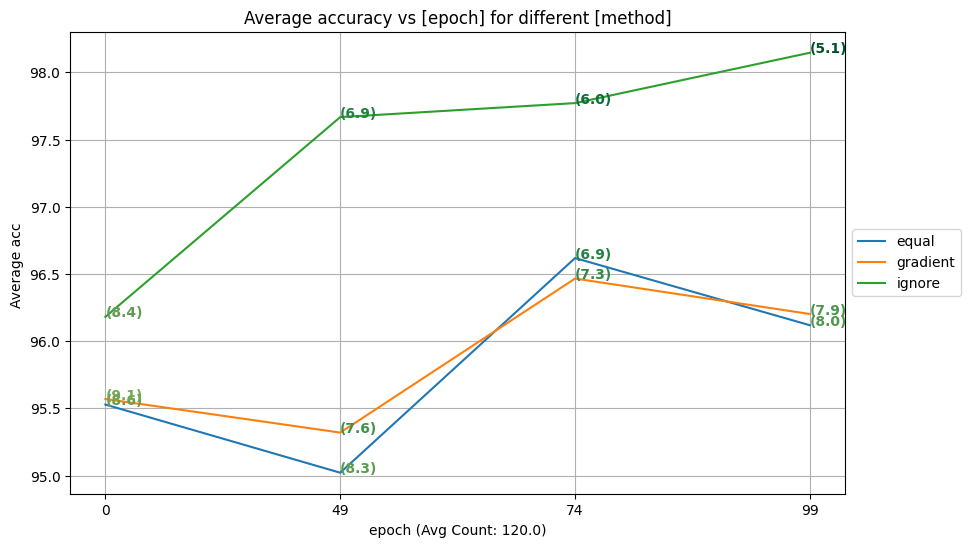

In [122]:
filt_out={}#{'used_regressor': 'diff_regressor'}


#all_plots(case25_0_,figsize=(5,2),points_notation='std',filter_out=filt_out)
plot_avg_accuracy(case25_0_, 'epoch', 'method',filter_out=filt_out,points_notation='std')

In [123]:
print('Full size:',60*4*3)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/26.0_pick_time_pixel(Np=4)/plots'
case26_0_ = extract_values(path)

print(len(case26_0_))
case26_0_

Full size: 720
data: 633
data_full_pixel: 633
Detected units: {'Bt': 'mT'}
633


,method,Bt,df,used_regressor,epoch,accuracy,accuracy(full pixel)
0,gradient,3.4,0.8,max_value_regressor,49,100.00,100.00
1,gradient,3.4,0.8,logistic_regressor,49,100.00,100.00
2,gradient,3.4,0.8,diff_regressor,49,46.25,18.75
3,gradient,3.4,0.8,max_value_regressor,0,75.00,48.75
4,gradient,3.4,0.8,logistic_regressor,0,93.75,93.75
...,...,...,...,...,...,...,...
628,gradient,5.8,0.2,logistic_regressor,36,85.00,96.25
629,gradient,5.8,0.2,diff_regressor,36,47.50,25.00
630,gradient,5.8,0.2,max_value_regressor,24,75.00,73.75
631,gradient,5.8,0.2,logistic_regressor,24,95.00,95.00


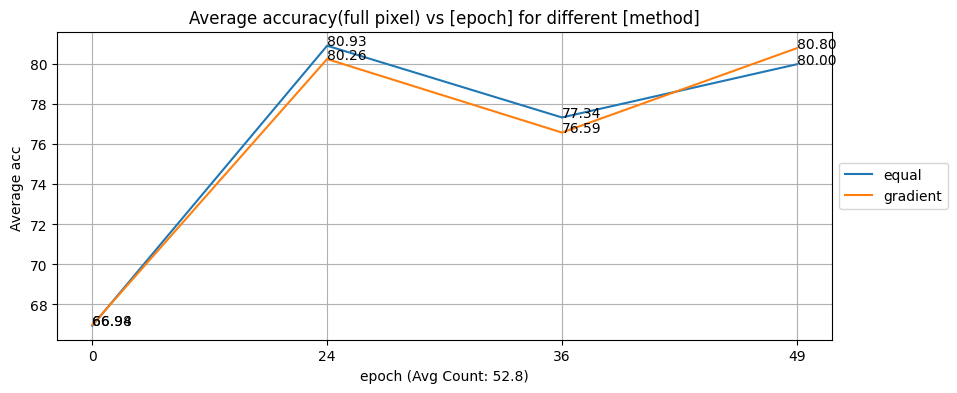

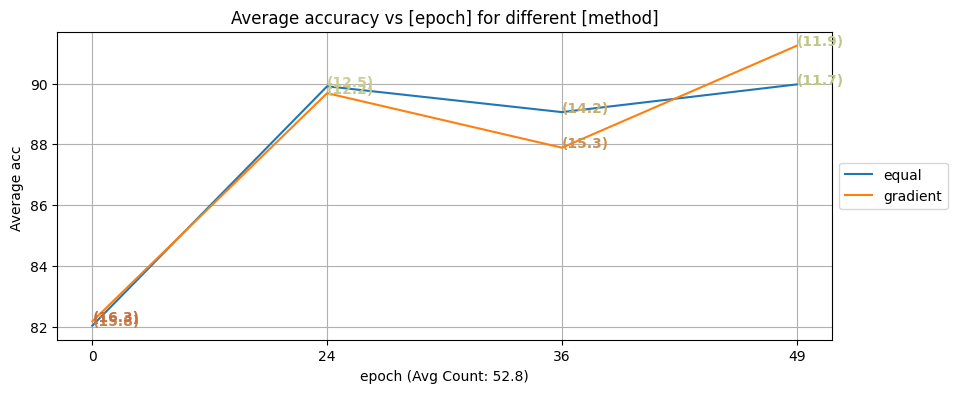

In [128]:
filt_out={'used_regressor': 'diff_regressor'}
#filt_out={}

#all_plots(case26_0_,figsize=(5,2),points_notation='std',filter_out=filt_out)
plot_avg_accuracy(case26_0_, 'epoch', 'method',filter_out=filt_out,points_notation='val', figsize=(10,4),score_column='accuracy(full pixel)')
plot_avg_accuracy(case26_0_, 'epoch', 'method',filter_out=filt_out,points_notation='std', figsize=(10,4))

In [85]:
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/27.0_basic_test_df_dt/plots/'
case27_0_ = extract_values(path)

print(len(case27_0_))
case27_0_

KeyError: 'accuracy'

# pixel method visualization

In [25]:
def extract_params(directory_name, units):
    # Split the directory_name and construct the parameter dictionary directly
    params_dict = {}
    first_part_params = directory_name.split(',')
    for param in first_part_params:
        name, val = param.split('=')
        
        # Remove square brackets from the value
        val = val.replace('[', '').replace(']', '')

        # Extract numeric part of the value using regex
        numeric_val = re.search(r'-?\d+\.?\d*', val)
        if numeric_val:
            params_dict[name] = numeric_val.group()
            # Storing the unit separately in the units dictionary
            unit = re.search(r'[a-zA-Z]+$', val)
            if unit and name not in units:
                units[name] = unit.group()
        else:
            # In case the value is not numeric (like 'method'), just save it directly
            params_dict[name] = val
    return params_dict, units

def clean_file_name_pixels(file):
    # Remove the prefix and suffix
    filename = file.replace("model_acc_for_diff_pixel_", "").replace(".txt", "")
    
    # The remaining part is the regressor type
    return filename

def read_file_data(file_path):
    # Open the file as a text file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Initialize a list to store each row as a dictionary
    rows = []
    
    # Skip the first two lines, and process the rest
    for line in lines[2:]:
        row = {}

        # Extract the values using string processing or regex methods
        # The regex pattern captures two accuracy percentages and three pixel values from each line
        match = re.search(r'validation acc:(\d+\.\d+)%, test acc:(\d+\.\d+)%, pixel:\[(\d+), (\d+), (\d+)\]', line)
        if match:

            row['pixel_start_pos'] = match.group(3)
            row['pixel_size'] = match.group(4)
            row['pixel_avail'] = match.group(5)
            row['validation_acc'] = match.group(1)
            row['test_acc'] = match.group(2)
        
            rows.append(row)
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(rows)
    
    return df

def combine_params_and_data(params_dict, df):
    for key in params_dict:
        df[key] = params_dict[key]
    return df

def extract_pixels_value(main_path):
    # Prepare an empty DataFrame to store data
    data = pd.DataFrame()

    # Initialize dictionary to store units
    units = {}

    # Loop through each directory
    for root, dirs, _ in tqdm(os.walk(main_path)):
        # Check if the specific subdirectory is in the directory
        for directory in dirs:
            match = re.match(r"model_test_e(\d+)$", directory)
            if match:
                model_number = match.group(1)
                model_dir = os.path.join(root, directory)

                # Iterate over files in the model directory
                for _, _, files in os.walk(model_dir):
                    for file in files:
                        if re.search(r'model_acc_for_diff_pixel_.*\.txt$', file):
                            file_path = os.path.join(model_dir, file)

                            # Check if the specific file is in the subdirectory
                            if os.path.exists(file_path):
                                directory_name = re.search(r"\((.*?)\)", os.path.basename(root)).group(1)
                                params_dict, units = extract_params(directory_name, units)
                                params_dict['used_regressor'] = clean_file_name_pixels(file)
                                params_dict['epoch'] = model_number

                                # Read data from the file
                                df = read_file_data(file_path)

                                # Combine params_dict with df
                                df = combine_params_and_data(params_dict, df)

                                # Append df to data
                                data = pd.concat([data, df], ignore_index=True)

    # Sort the columns of the DataFrame
    sorted_columns = sorted(data.columns.tolist(), key=lambda x: x not in params_dict)
    data = data[sorted_columns]

    # Print detected units
    print('Detected units:', units)
    data['validation_acc']=pd.to_numeric(data['validation_acc'])
    data['test_acc']=pd.to_numeric(data['test_acc'])
    return data


In [67]:
print('Full size:',120*4*3)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/25.0_large_df_method_compare/plots'
case25_0_pixel = extract_pixels_value(path)
pixel_cob=(10 * (10 + 1)) // 2
print('all pixels size:',120*4*3*pixel_cob)
print(len(case25_0_pixel))
case25_0_pixel

Full size: 1440


720it [00:14, 50.98it/s] 


Detected units: {'Bt': 'mT', 'df': 'GHz'}
all pixels size: 79200
79035


,method,Bt,df,used_regressor,epoch,pixel_start_pos,pixel_size,pixel_avail,validation_acc,test_acc
0,equal,4.0,1.5,max_value_regressor,49,0,10,10,100.00,100.00
1,equal,4.0,1.5,max_value_regressor,49,1,9,10,100.00,100.00
2,equal,4.0,1.5,max_value_regressor,49,0,9,10,100.00,100.00
3,equal,4.0,1.5,max_value_regressor,49,2,8,10,100.00,100.00
4,equal,4.0,1.5,max_value_regressor,49,1,8,10,100.00,100.00
...,...,...,...,...,...,...,...,...,...,...
79030,equal,3.0,1.5,diff_regressor,99,4,1,10,50.00,50.00
79031,equal,3.0,1.5,diff_regressor,99,3,1,10,50.00,50.00
79032,equal,3.0,1.5,diff_regressor,99,2,1,10,83.33,80.00
79033,equal,3.0,1.5,diff_regressor,99,1,1,10,83.33,78.33


In [71]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def darken_cmap(cmap):
    cmap = cm.get_cmap(cmap)
    cmap_data = cmap(np.arange(cmap.N))
    
    # change the first RGB columns in each row (which form the colors) by taking
    # half their current value, effectively darkening the colormap
    cmap_data[:, :3] = cmap_data[:, :3] * 0.8
    
    return LinearSegmentedColormap.from_list('darkened_' + cmap.name, cmap_data, cmap.N)

def plot_avg_accuracy(df, x_param, line_param, filter_out=None, figsize=(10,6), points_notation=None,score_column='accuracy'):
    # Apply the filter condition if provided
    if filter_out:
        for column, conditions in filter_out.items():
            if not isinstance(conditions, list):
                conditions = [conditions]
            for condition in conditions:
                df = df[df[column] != condition]

    # Calculate average accuracy and standard deviation grouped by x_param and line_param
    grouped = df.groupby([x_param, line_param]).agg({score_column: ['mean', 'std', 'size']}).reset_index()

    # Flatten the multi-level columns
    grouped.columns = ['_'.join(t).rstrip('_') for t in grouped.columns.values]

    # Rename columns for convenience
    grouped = grouped.rename(columns={f"{score_column}_mean": score_column, f"{score_column}_std": "std", f"{score_column}_size": "counts"})

    # Get unique line parameters
    unique_lines = grouped[line_param].unique()

    # Calculate the average count
    avg_count = grouped['counts'].mean()

    # Create a colormap and normalize object
    cmap = darken_cmap('RdYlGn_r') # '_r' indicates reverse order, so high values will be red and low values green
    norm = colors.Normalize(vmin=5, vmax=20) # values <=5 will be most green, >=20 will be most red

    # Create a new figure
    plt.figure(figsize=figsize)

    # Loop through each unique line parameter
    for line_val in unique_lines:
        # Filter the grouped DataFrame for the current line parameter
        line_data = grouped[grouped[line_param] == line_val]

        # Plot the data for this line parameter
        plt.plot(line_data[x_param], line_data[score_column], label=str(line_val))

        # Add data point count or standard deviation as text annotation next to each data point if points_notation is not None
        if points_notation:
            for i, point in line_data.iterrows():
                if points_notation == 'std':
                    annotation = f"({point['std']:.1f})"
                    color = cmap(norm(point['std'])) if point['std'] <= 20 else cmap(1.0) # Maximum red color for std>20
                elif points_notation == 'sp_count':
                    annotation = f"({point['counts']})"
                    color = 'black'
                plt.text(point[x_param], point[score_column], annotation, color=color, fontweight='bold')

    # Add a legend, grid, labels and a title
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.xlabel(f"{x_param} (Avg Count: {avg_count:.1f})")
    plt.ylabel(f'Average acc ')
    plt.title(f'Average {score_column} vs [{x_param}] for different [{line_param}]')
    plt.show()
def all_plots(data_df,figsize,filter_out={},points_notation=False):
    for x_axis in data_df.columns[:-2]:
        for p_lines in data_df.columns[:-2]:
            if x_axis == p_lines:
                continue
            print(x_axis,p_lines)
            plot_avg_accuracy(data_df, x_axis, p_lines,filter_out=filter_out,figsize=figsize,points_notation=points_notation)

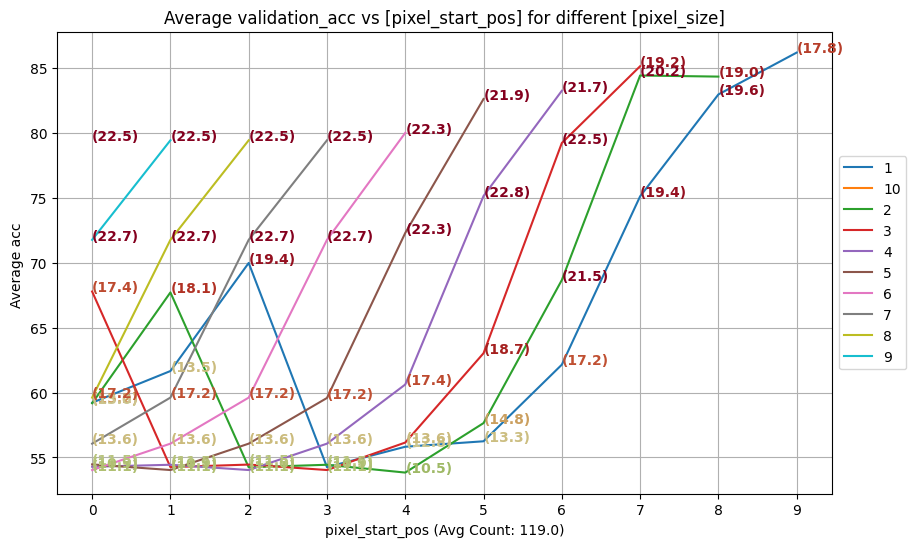

In [101]:
filt_out = {'used_regressor': ['diff_regressor','logistic_regressor'],'epoch': ['0', '49','74']}#{'used_regressor': 'diff_regressor'}


#all_plots(case25_0_,figsize=(5,2),points_notation='std',filter_out=filt_out)
plot_avg_accuracy(case25_0_pixel, 'pixel_start_pos', 'pixel_size',filter_out=filt_out,points_notation='std',score_column='validation_acc')

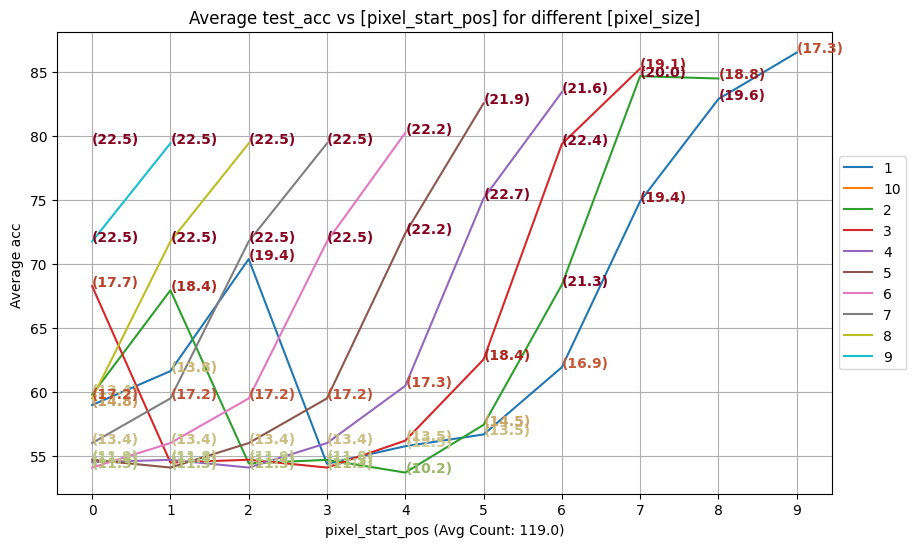

In [100]:
filt_out = {'used_regressor': ['diff_regressor','logistic_regressor'],'epoch': ['0', '49','74']}#{'used_regressor': 'diff_regressor'}


#all_plots(case25_0_,figsize=(5,2),points_notation='std',filter_out=filt_out)
plot_avg_accuracy(case25_0_pixel, 'pixel_start_pos', 'pixel_size',filter_out=filt_out,points_notation='std',score_column='test_acc')